***Method***

In [1]:
DIM_MODEL = 128
NUM_BLOCK = 1
NUM_HEAD = 4
DROPOUT = 0.5
FE = 1

BATCH_SIZE = 16
NUM_EPOCHS = 50
TEACHER_FORCING_RATE = 0.0
LEARNING_RATE = 0.001
ATTENTION_IMAGE_OUTPUT_PATH = 'attention image'

SMILES_DATA_PATH = '../data/ADAGRASIB_UNIQUE_SMILES.txt'
COORDINATE_DATA_PATH = '../data/ADAGRASIB_COOR.sdf'

In [141]:
import rdkit
import pandas as pd
import numpy as np 
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 

In [199]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_all_atom(smi_path) :
    smi_dic = {}
    i = 0

    with open(smi_path, 'r') as file :
        for smi in file :
            smi = rdkit.Chem.MolFromSmiles(smi)
            for atom in smi.GetAtoms() :
                atom = atom.GetSymbol()
                if atom not in smi_dic : 
                    smi_dic[atom] = i 
                    i += 1
    return smi_dic

def replace_atom(input, mode = 'train') :
    if mode == 'train' :
        smi_list = [smi.replace('Cl', 'X')
                    .replace('Br', 'Y')
                    .replace('Na', 'Z')
                    .replace('Ba', 'T') for smi in input]
        return smi_list
        
    if mode == 'eval' :
        smi = input.replace('X', 'Cl').replace('Y', 'Br').replace('Z', 'Na').replace('T', 'Ba').replace('E','')
        return smi

def get_longest(input_list) :
    longest = 0
    for i in input_list :
        if len(i) > longest :
            longest = len(i)
    return longest

def get_coor(coor_path) :
    coor_list = []
    supplier = rdkit.Chem.SDMolSupplier(coor_path)
    for mol in supplier:
        coor = []
        if mol is not None:
            conformer = mol.GetConformer()
            for atom in mol.GetAtoms():
                atom_idx = atom.GetIdx()
                x, y, z = conformer.GetAtomPosition(atom_idx)
                coor_atom = list((x,y,z))
                coor.append(coor_atom)
        coor_list.append(coor)

    # Replace invalid idx
    for i, coor in enumerate(coor_list):
        
        if len(coor) == 0 :
            if i == 0 :
                coor_list = coor_list[1:]
            coor_list[i] = coor_list[i-1]
    return coor_list

def get_smi(smi_path) :
    smi_list = []
    i = 0
    with open(smi_path, 'r') as file :
        for smi in file :
            if rdkit.Chem.MolFromSmiles(smi) is None :
                if len(smi_list) == 0 :
                    continue 
                smi_list.append(smi_list[i-1])
                i += 1 
                continue 
            smi_list.append(smi)
            i += 1
    
    smi_list = [smi[:-1] for smi in smi_list]
    smi_list = [smi + 'E' for smi in smi_list]
    smi_list = replace_atom(smi_list)
    return smi_list

def get_dic(smi_list) :
    smi_dic = {'x': 0,
               'E': 1}
    i = len(smi_dic)

    for smi in smi_list : 
        for atom in smi :
            if atom not in smi_dic : 
                smi_dic[atom] = i
                i += 1 
    return smi_dic 

def count_atoms(smi):
    mol = rdkit.Chem.MolFromSmiles(smi)
    if mol is not None:
        num_atoms = mol.GetNumAtoms()
        return num_atoms
    else:
        print("Error: Unable to parse SMILES string.")
        return None
    
def smi2int(smi, smi_dic, longest_smi, mode = 'data') :
    if mode == 'eval' :
        # smi += 'E'
        smi = smi + 'E' if smi[-1] != 'E' else smi
        smi = list(smi)
        smint = [smi_dic[atom] for atom in smi]
        smint = smint + [0] * (longest_smi - len(smint))
        smint = torch.tensor(smint, dtype=torch.long, device = device)
        smint = smint.unsqueeze(0)
        return smint
    smi = list(smi)
    smint = [smi_dic[atom] for atom in smi]
    smint = smint + [0] * (longest_smi - len(smint))
    return smint 



def normalize_coor(coor_list) :
    n_coor_list = []

    for mol_coor in coor_list :
        n_mol_coor = []

        x_origin, y_origin, z_origin = mol_coor[0]

        for atom_coor in mol_coor :
            n_atom_coor = [round(atom_coor[0] - x_origin, 2), 
                        round(atom_coor[1] - y_origin, 2), 
                        round(atom_coor[2] - z_origin, 2)]
            n_mol_coor.append(n_atom_coor)
        n_coor_list.append(n_mol_coor)
    return n_coor_list

def pad_coor(coor_list, longest_coor) :
    p_coor_list = []

    for i in coor_list :
        if len(i) < longest_coor :
            zeros = [[0,0,0]] * (longest_coor - len(i))
            zeros = torch.tensor(zeros)
            i = torch.tensor(i)
            i = torch.cat((i, zeros), dim = 0)
            p_coor_list.append(i)
        else :
            p_coor_list.append(i)
    return p_coor_list

def train_test_split(input, ratio = 0.9) :
    ratio = int(len(input) * ratio) 

    train = input[:ratio]
    test = input[ratio:]
    return train, test

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def evaluate(input, encoder, decoder, smi_dic, longest_smi) :
    input = smi2int(input, smi_dic, longest_smi, mode = 'eval')
    
    with torch.no_grad() :
        e_all, e_last, self_attn = encoder(input) 
        prediction, cross_attn = decoder(e_all, e_last)

        prediction, self_attn, cross_attn = prediction.squeeze(0), self_attn.squeeze(0), cross_attn.squeeze(0)
    return prediction, self_attn, cross_attn

def plot_attn(matrix, smi, mode, output_path = "", output_name = "") :
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix, cmap = "viridis")
    fig.colorbar(cax)

    if mode == "cross" :
        ax.set_xticklabels([''] + list(smi))
        # ax.set_yticklabels([''])
    if mode == "self" :
        ax.set_xticklabels([''] + list(smi))
        ax.set_yticklabels([''] + list(smi))
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.savefig(f"{output_path}/{output_name}.png")
    plt.show()

def visualize(smi,
              encoder, decoder,
              smi_dic, longest_smi,
              output_path = "",
              output_name="") :
    
    prediction, self_attn, cross_attn = evaluate(smi, encoder, decoder, smi_dic, longest_smi)

    self_attn = self_attn.cpu().numpy()
    cross_attn = cross_attn.cpu().numpy()

    smi = replace_atom(smi, mode='eval')

    coor_len = count_atoms(smi)
    smi_len = len(smi) 
    
    for i, head in enumerate(self_attn, 1) :
        head = head[:smi_len, :smi_len]
        plot_attn(head, smi, mode = 'self', output_path=output_path, output_name=f'HEAD{i}-SELF-{output_name}')

    cross_attn = cross_attn[:coor_len, :smi_len]
    plot_attn(cross_attn, smi, mode = 'cross', output_path=output_path, output_name=f'CROSS-{output_name}')


    


In [162]:
smi_list = get_smi(SMILES_DATA_PATH)
longest_smi = get_longest(smi_list)
smi_dic = get_dic(smi_list)
smint_list = [smi2int(smi, smi_dic, longest_smi) for smi in smi_list]


coor_list = get_coor(COORDINATE_DATA_PATH)
longest_coor = get_longest(coor_list)
np_coor_list = pad_coor(normalize_coor(coor_list), longest_coor)


train_smint, test_smint = train_test_split(smint_list)
train_coor, test_coor =train_test_split(np_coor_list)

In [5]:
class ADAGRASIB_Dataset(Dataset) :
    def __init__(self, smi_list, coor_list) :
        self.smi_list = torch.tensor(smi_list, dtype = torch.long, device=device)
        self.coor_list = [torch.tensor(coor) for coor in coor_list]

    def __len__(self) :
        return len(self.smi_list)
    
    def __getitem__(self, idx) :
        return self.smi_list[idx], self.coor_list[idx]
    
train_set = ADAGRASIB_Dataset(train_smint, train_coor)
test_set = ADAGRASIB_Dataset(test_smint, test_coor)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_9724\3236956238.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.coor_list = [torch.tensor(coor) for coor in coor_list]


In [6]:
class NN_Attention(nn.Module): # Neural Network Attention 
    def __init__(self, dim_model):
        super(NN_Attention, self).__init__()
        self.Wa = nn.Linear(dim_model, dim_model)
        self.Ua = nn.Linear(dim_model, dim_model)
        self.Va = nn.Linear(dim_model, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)

        context = torch.bmm(weights, keys)

        return context, weights 
    

class DP_Attention(nn.Module) : # Dot Product Attention
    def __init__(self, dim_model, num_head) :
        super(DP_Attention, self).__init__()
        self.dim_model = dim_model
        self.num_head = num_head
        self.dim_head = dim_model // num_head

        self.Q = nn.Linear(dim_model, dim_model)
        self.K = nn.Linear(dim_model, dim_model)
        self.V = nn.Linear(dim_model, dim_model)

        self.out = nn.Linear(dim_model, dim_model)

    def forward(self, Q, K, V) :
        B = Q.size(0) # Shape Q, K, V: (B, longest_smi, dim_model)

        Q, K, V = self.Q(Q), self.K(K), self.V(V)

        len_Q, len_K, len_V = Q.size(1), K.size(1), V.size(1)

        Q = Q.reshape(B, self.num_head, len_Q, self.dim_head)
        K = K.reshape(B, self.num_head, len_K, self.dim_head)
        V = V.reshape(B, self.num_head, len_V, self.dim_head)
        
        K_T = K.transpose(2,3).contiguous()

        attn_score = Q @ K_T

        attn_score = attn_score / (self.dim_head ** 1/2)

        attn_distribution = torch.softmax(attn_score, dim = -1)

        attn = attn_distribution @ V

        attn = attn.reshape(B, len_Q, self.num_head * self.dim_head)
        
        attn = self.out(attn)

        return attn, attn_distribution

In [7]:
class EncoderBlock(nn.Module) :
    def __init__(self, dim_model, num_head, fe, dropout) :
        super(EncoderBlock, self).__init__()

        self.Self_Attention = DP_Attention(dim_model,num_head)
        self.LSTM = nn.LSTM(input_size=2 * dim_model, hidden_size=dim_model, batch_first=True)

    def forward(self, Q, K, V) :

        attn, self_attn = self.Self_Attention(Q, Q, Q)

        input_lstm = torch.cat((Q, attn), dim = -1)

        all_state, (last_state, _) = self.LSTM(input_lstm)

        return all_state, last_state, self_attn


class Encoder(nn.Module) :
    def __init__(self, dim_model, num_block, num_head, len_dic, fe = 1, dropout = 0.1) :
        super(Encoder, self).__init__()

        self.Embedding = nn.Embedding(len_dic, dim_model)
        self.Dropout = nn.Dropout(dropout)
        self.encoder_blocks = nn.ModuleList(
            EncoderBlock(dim_model, num_head, fe, dropout) for _ in range(num_block)
        )

    def forward(self, x) :
        out = self.Dropout(self.Embedding(x))
        for block in self.encoder_blocks : 
            out, last_state, self_attn = block(out, out, out) 
        return out, last_state, self_attn

In [83]:
class GRU(nn.Module) :
    def __init__(self, dim_model, longest_coor,dropout, num_head = 1, output_size = 3) :
        super(GRU, self).__init__()

        self.longest_coor = longest_coor

        self.cross_attn_nn = NN_Attention(dim_model)

        self.gru = nn.GRU(3 + dim_model, dim_model, batch_first=True)

        self.out = nn.Linear(dim_model, output_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, e_all, e_last, target = None) :
        B = e_all.size(0)

        d_input = torch.zeros(B, 1, 3).to(device)

        d_hidden = e_last

        d_outputs, cross_attn = [], []

        for i in range(self.longest_coor) :
            d_output, d_hidden, step_attn = self.forward_step(d_input, d_hidden, e_all)

            d_outputs.append(d_output), cross_attn.append(step_attn)

            if target is not None :
                d_input = target[:, i, :].unsqueeze(1)
            else :
                d_input = d_output

        d_outputs = torch.cat(d_outputs, dim = 1)

        cross_attn = torch.cat(cross_attn, dim = 1)
        
        return d_outputs, d_hidden, cross_attn


    def forward_step(self, d_input, d_hidden, e_all) :
        Q = d_hidden.permute(1,0,2)

        d_input = self.dropout(d_input)

        attn, attn_distribution = self.cross_attn_nn(Q, e_all)

        input_lstm = torch.cat((attn, d_input), dim = 2)

        output, d_hidden = self.gru(input_lstm, d_hidden) 
        
        output = self.out(output)

        return output, d_hidden, attn_distribution
    

class DecoderBlock(nn.Module) :
    def __init__(self, dim_model, num_head, longest_coor, fe, dropout) :
        super(DecoderBlock, self).__init__()

        self.gru = GRU(dim_model, longest_coor,dropout, num_head)


    def forward(self, e_all, e_last, target = None) :
        output, _, cross_attn = self.gru(e_all, e_last, target)
        
        return output, cross_attn
    
class Decoder(nn.Module) :
    def __init__(self, dim_model,num_block, num_head, longest_coor, fe = 1, dropout = 0.1) :
        super(Decoder, self).__init__()

        self.decoder_blocks = nn.ModuleList(
            [DecoderBlock(dim_model, num_head,longest_coor, fe, dropout) for _ in range(num_block)]
        )

        
    def forward(self, e_all, e_last, target = None) :
        for block in self.decoder_blocks :
            target, cross_attn = block(e_all, e_last, target)
        return target, cross_attn



In [84]:
def train_epoch(train_loader,test_loader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion, tf):

    total_loss = 0
    total_test_loss = 0

    for input, target in train_loader:
        input, target = input.to(device), target.to(device)

        encoder_optimizer.zero_grad(), decoder_optimizer.zero_grad()
        
        e_all, e_last, self_attn = encoder(input)

        # Teacher Forcing
        if tf :
          prediction, cross_attn = decoder(e_all, e_last, target)
        else :
          prediction, cross_attn = decoder(e_all, e_last)


        loss = criterion(prediction, target)
        loss.backward()

        encoder_optimizer.step(), decoder_optimizer.step()
        
        total_loss += loss.item()


    encoder.eval(), decoder.eval()
    


    with torch.no_grad() :
      for input, target in test_loader :
        input, target = input.to(device), target.to(device)
        
        e_all, e_last, self_attn = encoder(input)
        prediction, cross_attn = decoder(e_all, e_last)

        test_loss = criterion(prediction, target)
        total_test_loss += test_loss.item()

    return total_loss / len(train_loader), total_test_loss / len(test_loader)

def train(train_loader, test_loader,
          encoder, decoder, 
          num_epoch=50,
          learning_rate=0.001, tf_rate = 1,
          print_frequency=1, plot_frequency=1):
    start = time.time()

    # train_loss_total = 0  
    # test_loss_total = 0

    train_plot, test_plot = [], []

    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

    criterion = nn.L1Loss()

    tf = True

    for epoch in range(1, num_epoch + 1):
      if epoch > (tf_rate * num_epoch) :
        tf = False
      encoder.train()
      decoder.train()

      train_loss, test_loss = train_epoch(train_loader, test_loader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, tf)
      # train_loss_total += train_loss
      # test_loss_total += test_loss

      print('%s (%d %d%%) /// Train loss: %.4f - Test loss: %.4f' % (timeSince(start, epoch / num_epoch),
                                      epoch, epoch / num_epoch * 100, train_loss, test_loss))

      if epoch == 1 : 
        continue
      train_plot.append(train_loss), test_plot.append(test_loss)
      x = np.linspace(0, num_epoch, epoch)
      plt.clf()
      plt.plot(x, train_plot, color = 'blue', label = 'Train Loss')
      plt.plot(x, test_plot, color = 'red', label = 'Train Loss')
      plt.legend()
      plt.show()
      
      # if epoch % print_frequency == 0:
      #     train_loss_avg = train_loss_total / print_frequency
      #     test_loss_avg = test_loss_total / print_frequency
      #     train_loss_total = 0
      #     test_loss_total = 0
          # print('%s (%d %d%%) /// Train loss: %.4f - Test loss: %.4f' % (timeSince(start, epoch / num_epoch),
          #                             epoch, epoch / num_epoch * 100, train_loss_avg, test_loss_avg))
      #     x = np.arange(0, len(train_plot))
      #     plt.plot(x, train_plot)
      #     plt.show()
      
      # if epoch % 
          


In [124]:
encoder = Encoder(dim_model=DIM_MODEL,
                  num_block=NUM_BLOCK,
                  num_head=4,
                  dropout=DROPOUT,
                  fe = FE,
                  len_dic=len(smi_dic)).to(device)

decoder = Decoder(dim_model=DIM_MODEL,
                  num_block=NUM_BLOCK,
                  num_head=NUM_HEAD,
                  dropout=DROPOUT,
                  fe=FE,
                  longest_coor=longest_coor,
                  ).to(device)

In [125]:
train(train_loader, test_loader, encoder, decoder,
      num_epoch=NUM_EPOCHS,
      learning_rate=LEARNING_RATE,
      tf_rate = TEACHER_FORCING_RATE,
      )

KeyboardInterrupt: 

C:\Users\DELL\AppData\Local\Temp\ipykernel_9724\3024452515.py:185: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(smi))
C:\Users\DELL\AppData\Local\Temp\ipykernel_9724\3024452515.py:186: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(smi))


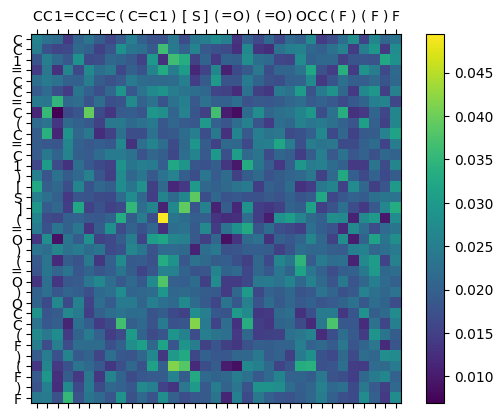

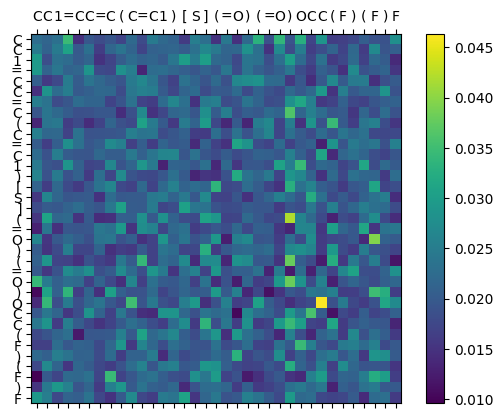

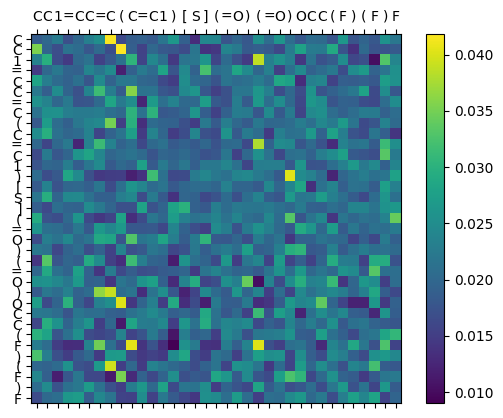

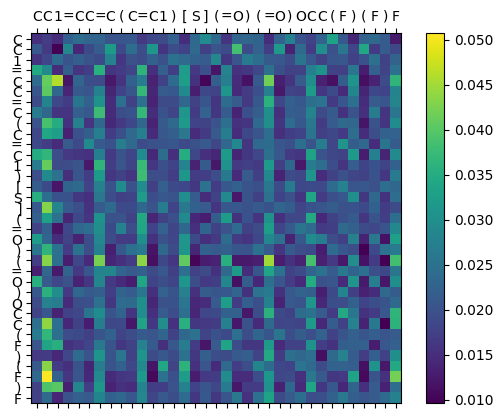

C:\Users\DELL\AppData\Local\Temp\ipykernel_9724\3024452515.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(smi))


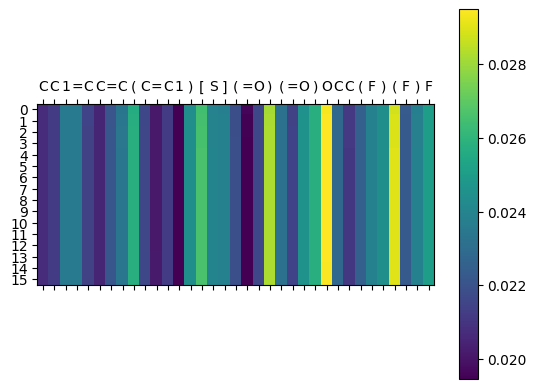

In [200]:
visualize(smi_list[1], encoder, decoder, smi_dic, longest_smi,output_path="image", output_name='test')